C:\Users\14488\AppData\Local\Temp\ipykernel_12632\1072947090.py:220: UserWarning: PySoundFile failed. Trying audioread instead.
  chunk_data, _ = librosa.load(self.file_path, sr=self.sample_rate, mono=True,


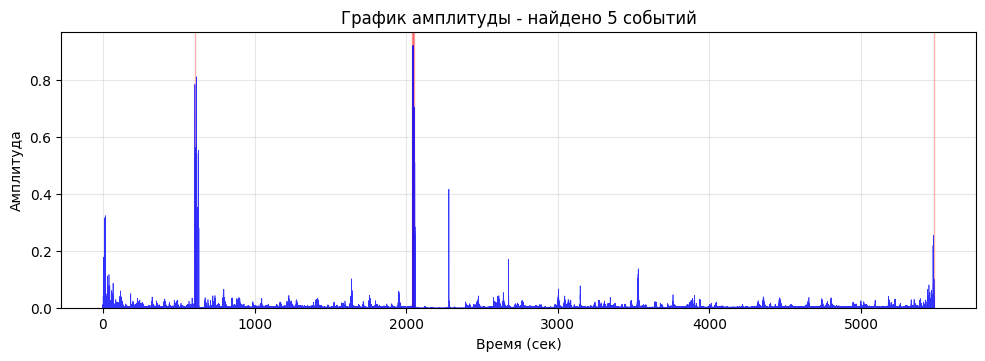

Exception in thread Thread-27 (play_audio_at_time):
Traceback (most recent call last):
  File "C:\Users\14488\AppData\Local\Temp\ipykernel_12632\1072947090.py", line 315, in play_audio_at_time
  File "C:\Users\14488\AppData\Local\Temp\ipykernel_12632\1072947090.py", line 587, in update_progress
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\tkinter\__init__.py", line 872, in after
    name = self._register(callit)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\tkinter\__init__.py", line 1603, in _register
    self.tk.createcommand(name, f)
RuntimeError: main thread is not in main loop

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1045, in _bootst

In [10]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import librosa
import soundfile as sf
import sounddevice as sd
import os
import shutil
import math
from datetime import datetime, timedelta
import threading
import time

class AudioAnalyzer:
    def __init__(self, root):
        self.root = root
        self.root.title("Анализатор аудиофайлов - Обнаружение громких звуков")
        self.root.geometry("1200x800")
        
        # Переменные для данных
        self.sample_rate = None
        self.file_path = None
        self.events = []
        self.base_folder = None
        self.chunks_folder = None
        self.fragments_folder = None
        self.chunk_files = []
        self.full_waveform = None
        self.downsampled_rate = None
        
        # Создание интерфейса
        self.create_interface()
        
    def create_interface(self):
        # Главный фрейм
        main_frame = ttk.Frame(self.root)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Верхняя панель с кнопками и отчетом
        top_frame = ttk.Frame(main_frame)
        top_frame.pack(fill=tk.X, pady=(0, 10))
        
        # Левая панель с кнопками
        left_panel = ttk.Frame(top_frame)
        left_panel.pack(side=tk.LEFT, fill=tk.Y, padx=(0, 10))
        
        # Кнопки управления
        ttk.Button(left_panel, text="Загрузить аудиофайл", 
                   command=self.load_audio_file).pack(pady=5, fill=tk.X)
        
        # Настройки анализа
        settings_frame = ttk.LabelFrame(left_panel, text="Настройки анализа")
        settings_frame.pack(pady=5, fill=tk.X)
        
        # Пороговое значение
        ttk.Label(settings_frame, text="Порог громкости:").pack(anchor=tk.W, padx=5)
        self.threshold_var = tk.DoubleVar(value=0.01)
        self.threshold_var.trace_add("write", self.enforce_threshold_step)
        threshold_scale = ttk.Scale(settings_frame, from_=0.01, to=0.1, 
                                   variable=self.threshold_var, orient=tk.HORIZONTAL)
        threshold_scale.pack(fill=tk.X, padx=5)
        self.threshold_label = ttk.Label(settings_frame, text="0.01")
        self.threshold_label.pack(anchor=tk.W, padx=5)
        threshold_scale.configure(command=self.update_threshold_label)
        
        # Минимальная длительность события
        ttk.Label(settings_frame, text="Мин. длительность события (сек):").pack(anchor=tk.W, padx=5, pady=(10, 0))
        self.min_duration_var = tk.DoubleVar(value=0.0)
        self.min_duration_var.trace_add("write", self.enforce_min_duration_step)
        min_duration_scale = ttk.Scale(settings_frame, from_=0.0, to=3.0, 
                                      variable=self.min_duration_var, orient=tk.HORIZONTAL)
        min_duration_scale.pack(fill=tk.X, padx=5)
        self.min_duration_label = ttk.Label(settings_frame, text="0.0 сек")
        self.min_duration_label.pack(anchor=tk.W, padx=5)
        min_duration_scale.configure(command=self.update_min_duration_label)
        
        # Максимальная длительность события
        ttk.Label(settings_frame, text="Макс. длительность события (сек):").pack(anchor=tk.W, padx=5, pady=(10, 0))
        self.max_duration_var = tk.IntVar(value=1)
        max_duration_scale = ttk.Scale(settings_frame, from_=1, to=6, 
                                      variable=self.max_duration_var, orient=tk.HORIZONTAL)
        max_duration_scale.pack(fill=tk.X, padx=5)
        self.max_duration_label = ttk.Label(settings_frame, text="1 сек")
        self.max_duration_label.pack(anchor=tk.W, padx=5, pady=(0, 5))
        max_duration_scale.configure(command=self.update_max_duration_label)
        
        ttk.Button(left_panel, text="Анализировать", 
                   command=self.analyze_audio).pack(pady=5, fill=tk.X)
        
        ttk.Button(left_panel, text="Очистить все", 
                   command=self.clear_all).pack(pady=5, fill=tk.X)
        
        # Прогресс бар
        self.progress_label = ttk.Label(left_panel, text="Готов к работе")
        self.progress_label.pack(pady=5)
        
        self.progress_bar = ttk.Progressbar(left_panel, length=200, mode='determinate')
        self.progress_bar.pack(pady=5, fill=tk.X)
        
        # Правая панель с отчетом
        right_panel = ttk.Frame(top_frame)
        right_panel.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
        
        ttk.Label(right_panel, text="Отчет анализа:").pack(anchor=tk.W)
        
        # Текстовое поле для отчета
        self.report_text = tk.Text(right_panel, height=15, width=50)
        scrollbar = ttk.Scrollbar(right_panel, orient=tk.VERTICAL, command=self.report_text.yview)
        self.report_text.configure(yscrollcommand=scrollbar.set)
        
        self.report_text.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        
        # Нижняя панель с графиком
        bottom_frame = ttk.Frame(main_frame)
        bottom_frame.pack(fill=tk.BOTH, expand=True)
        
        # Создание графика
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.canvas = FigureCanvasTkAgg(self.fig, master=bottom_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Подключение обработчика событий для клика по графику
        self.canvas.mpl_connect('button_press_event', self.on_graph_click)
        
        # Начальная настройка графика
        self.ax.set_title("График амплитуды аудиосигнала (моно, положительная)")
        self.ax.set_xlabel("Время (сек)")
        self.ax.set_ylabel("Амплитуда")
        self.ax.set_ylim(0, None)
        self.canvas.draw()
        
    def enforce_threshold_step(self, *args):
        """Обеспечение шага 0.01 для порогового значения"""
        value = self.threshold_var.get()
        rounded_value = round(value, 2)
        if rounded_value < 0.01:
            rounded_value = 0.01
        elif rounded_value > 0.1:
            rounded_value = 0.1
        self.threshold_var.set(rounded_value)
        
    def enforce_min_duration_step(self, *args):
        """Обеспечение шага 0.3 для минимальной длительности"""
        value = self.min_duration_var.get()
        rounded_value = round(value / 0.3) * 0.3
        if rounded_value < 0.0:
            rounded_value = 0.0
        elif rounded_value > 3.0:
            rounded_value = 3.0
        self.min_duration_var.set(rounded_value)
        
    def update_threshold_label(self, value):
        """Обновление подписи порогового значения"""
        self.threshold_label.config(text=f"{self.threshold_var.get():.2f}")
    
    def update_min_duration_label(self, value):
        """Обновление подписи минимальной длительности события с шагом 0.3 сек"""
        rounded_value = round(float(value) / 0.3) * 0.3
        if rounded_value < 0.0:
            rounded_value = 0.0
        elif rounded_value > 3.0:
            rounded_value = 3.0
        self.min_duration_var.set(rounded_value)
        self.min_duration_label.config(text=f"{rounded_value:.1f} сек")
    
    def update_max_duration_label(self, value):
        """Обновление подписи максимальной длительности события с шагом 1 сек"""
        rounded_value = round(float(value))
        self.max_duration_var.set(rounded_value)
        self.max_duration_label.config(text=f"{rounded_value} сек")
    
    def load_audio_file(self):
        """Загрузка аудиофайла через диалоговое окно"""
        file_path = filedialog.askopenfilename(
            title="Выберите аудиофайл",
            filetypes=[("Audio files", "*.mp3 *.wav *.flac *.m4a"), ("All files", "*.*")]
        )
        
        if file_path:
            self.file_path = file_path
            threading.Thread(target=self.load_audio_thread, daemon=True).start()
    
    def create_folder_structure(self):
        """Создание структуры папок для хранения файлов"""
        base_name = os.path.splitext(os.path.basename(self.file_path))[0]
        self.base_folder = base_name
        
        if os.path.exists(self.base_folder):
            shutil.rmtree(self.base_folder)
        
        os.makedirs(self.base_folder)
        self.chunks_folder = os.path.join(self.base_folder, "chunks")
        self.fragments_folder = os.path.join(self.base_folder, "loud_fragments")
        os.makedirs(self.chunks_folder)
        os.makedirs(self.fragments_folder)
    
    def split_audio_file(self):
        """Разбиение аудиофайла на части"""
        CHUNK_DURATION = 300
        
        self.create_folder_structure()
        self.chunk_files = []
        
        total_duration = librosa.get_duration(path=self.file_path)
        self.sample_rate = librosa.get_samplerate(self.file_path)
        
        total_chunks = math.ceil(total_duration / CHUNK_DURATION)
        
        offset = 0
        chunk_index = 0
        
        while offset < total_duration:
            self.update_progress(f"Разбивка фрагмента {chunk_index + 1}/{total_chunks}...", 
                                (chunk_index / total_chunks) * 50)
            
            chunk_duration = min(CHUNK_DURATION, total_duration - offset)
            chunk_data, _ = librosa.load(self.file_path, sr=self.sample_rate, mono=True, 
                                        offset=offset, duration=chunk_duration)
            
            chunk_filename = os.path.join(self.chunks_folder, f"chunk_{chunk_index:03d}.wav")
            sf.write(chunk_filename, chunk_data, self.sample_rate)
            self.chunk_files.append((chunk_filename, offset))
            
            offset += chunk_duration
            chunk_index += 1
            
        return total_duration
    
    def load_audio_thread(self):
        """Загрузка аудио в отдельном потоке"""
        try:
            self.update_progress("Разбивка аудиофайла...", 0)
            total_duration = self.split_audio_file()
            
            self.update_progress("Подготовка данных для графика...", 50)
            self.prepare_full_waveform(total_duration)
            
            self.update_progress("Готов к анализу", 100)
            self.root.after(0, lambda: self.on_file_loaded(total_duration))
            
        except Exception as e:
            self.root.after(0, lambda: messagebox.showerror("Ошибка", f"Ошибка загрузки файла: {str(e)}"))
            self.update_progress("Ошибка загрузки", 0)
    
    def prepare_full_waveform(self, total_duration):
        """Подготовка данных для отображения полного графика"""
        MAX_PLOT_POINTS = 500000
        total_samples = int(total_duration * self.sample_rate)
        step = max(1, total_samples // MAX_PLOT_POINTS)
        
        self.full_waveform = []
        for chunk_file, offset in self.chunk_files:
            chunk_data, _ = librosa.load(chunk_file, sr=self.sample_rate, mono=True)
            chunk_data = np.abs(chunk_data[::step])
            self.full_waveform.extend(chunk_data)
        
        self.full_waveform = np.array(self.full_waveform)
        self.downsampled_rate = self.sample_rate / step
    
    def on_file_loaded(self, total_duration):
        """Вызывается после успешной загрузки файла"""
        filename = os.path.basename(self.file_path)
        file_size_bytes = os.path.getsize(self.file_path)
        file_size_mb = file_size_bytes / (1024 * 1024)
        
        report = f"Файл загружен: {filename}\n"
        report += f"Размер файла: {file_size_mb:.2f} МБ\n"
        report += f"Длительность: {total_duration:.2f} сек ({total_duration/3600:.2f} часов)\n"
        report += f"Частота дискретизации: {self.sample_rate} Гц\n"
        report += f"Число фрагментов: {len(self.chunk_files)}\n"
        report += f"Папка с чанками: {self.chunks_folder}\n"
        report += f"Папка для громких фрагментов: {self.fragments_folder}\n\n"
        
        self.report_text.delete(1.0, tk.END)
        self.report_text.insert(tk.END, report)
        self.plot_waveform()
    
    def on_graph_click(self, event):
        """Обработчик клика по графику для воспроизведения аудио"""
        if event.xdata is None or self.full_waveform is None:
            return
        
        click_time = event.xdata
        threading.Thread(target=self.play_audio_at_time, args=(click_time,), daemon=True).start()
    
    def play_audio_at_time(self, start_time):
        """Воспроизведение аудио с указанного времени"""
        try:
            chunk_file, chunk_offset = None, 0
            for file, offset in self.chunk_files:
                chunk_duration = librosa.get_duration(path=file)
                if offset <= start_time < offset + chunk_duration:
                    chunk_file, chunk_offset = file, offset
                    break
            
            if not chunk_file:
                return
            
            audio_data, _ = librosa.load(chunk_file, sr=self.sample_rate, mono=True)
            start_sample = int((start_time - chunk_offset) * self.sample_rate)
            
            if start_sample >= len(audio_data):
                return
            
            PLAY_DURATION = 10
            end_sample = min(len(audio_data), start_sample + int(PLAY_DURATION * self.sample_rate))
            audio_segment = audio_data[start_sample:end_sample]
            
            self.update_progress(f"Воспроизведение с {start_time:.2f} сек...", 100)
            sd.play(audio_segment, self.sample_rate)
            sd.wait()
            self.update_progress("Готов к работе", 100)
            
        except Exception as e:
            self.update_progress("Ошибка воспроизведения", 0)
    
    def plot_waveform(self):
        """Построение графика звуковой волны"""
        self.ax.clear()
        
        if self.full_waveform is None:
            self.ax.set_title("График амплитуды аудиосигнала (моно, положительная)")
            self.ax.set_xlabel("Время (сек)")
            self.ax.set_ylabel("Амплитуда")
            self.ax.set_ylim(0, None)
            self.canvas.draw()
            return
        
        duration = len(self.full_waveform) / self.downsampled_rate
        time_axis = np.linspace(0, duration, len(self.full_waveform))
        
        self.ax.plot(time_axis, self.full_waveform, 'b-', linewidth=0.5, alpha=0.8)
        self.ax.set_title("График амплитуды аудиосигнала (моно, положительная)")
        self.ax.set_xlabel("Время (сек)")
        self.ax.set_ylabel("Амплитуда")
        self.ax.set_ylim(0, None)
        self.ax.grid(True, alpha=0.3)
        
        self.canvas.draw()
    
    def analyze_audio(self):
        """Анализ аудио для обнаружения громких звуков"""
        if not self.chunk_files:
            messagebox.showwarning("Предупреждение", "Сначала загрузите аудиофайл")
            return
        
        threading.Thread(target=self.analyze_audio_thread, daemon=True).start()
    
    def analyze_audio_thread(self):
        """Анализ аудио в отдельном потоке"""
        try:
            self.events = []
            total_duration = 0
            debug_info = []
            
            for chunk_index, (chunk_file, offset) in enumerate(self.chunk_files):
                self.update_progress(f"Анализ фрагмента {chunk_index + 1}/{len(self.chunk_files)}...", 
                                    20 + (chunk_index / len(self.chunk_files)) * 60)
                
                chunk_data, _ = librosa.load(chunk_file, sr=self.sample_rate, mono=True)
                chunk_duration = len(chunk_data) / self.sample_rate
                total_duration += chunk_duration
                
                # Окно 50мс
                window_size = int(0.05 * self.sample_rate)
                hop_size = window_size // 2
                threshold = self.threshold_var.get()
                
                # Вычисление RMS энергии
                rms_energy = []
                for i in range(0, len(chunk_data) - window_size, hop_size):
                    window = chunk_data[i:i + window_size]
                    rms = np.sqrt(np.mean(window**2))
                    rms_energy.append(rms)
                
                rms_energy = np.array(rms_energy)
                loud_samples = rms_energy > threshold
                
                debug_info.append(f"Чанк {chunk_index + 1}: RMS max={rms_energy.max():.3f}, "
                                 f"громких окон={np.sum(loud_samples)}/{len(loud_samples)}")
                
                # Поиск событий
                events = self.find_events(loud_samples, hop_size, offset, chunk_duration)
                self.events.extend(events)
            
            # Добавляем отладочную информацию в отчет
            self.update_progress("Сохранение фрагментов...", 80)
            self.save_loud_fragments()
            
            # Создание отчета
            debug_report = "\n".join(debug_info) + f"\nОбнаружено событий: {len(self.events)}\n"
            self.create_report(total_duration, debug_report)
            self.update_progress("Анализ завершен", 100)
            self.root.after(0, self.plot_results)
            
        except Exception as e:
            self.root.after(0, lambda: messagebox.showerror("Ошибка", f"Ошибка анализа: {str(e)}"))
            self.update_progress("Ошибка анализа", 0)
    
    def find_events(self, loud_samples, hop_size, offset, chunk_duration):
        """Поиск событий с улучшенной логикой"""
        events = []
        in_event = False
        event_start = 0
        min_event_duration = self.min_duration_var.get()
        max_event_duration = self.max_duration_var.get()
        
        for i in range(len(loud_samples)):
            if loud_samples[i] and not in_event:
                event_start = i
                in_event = True
            elif (not loud_samples[i] or i == len(loud_samples)-1) and in_event:
                start_time = event_start * hop_size / self.sample_rate + offset
                end_time = (i + (1 if i == len(loud_samples)-1 else 0)) * hop_size / self.sample_rate + offset
                end_time = min(end_time, offset + chunk_duration)
                duration = end_time - start_time
                
                if min_event_duration <= duration <= max_event_duration:
                    events.append({
                        'start_time': start_time,
                        'end_time': end_time,
                        'duration': duration,
                        'start_sample': int(start_time * self.sample_rate),
                        'end_sample': int(end_time * self.sample_rate)
                    })
                
                in_event = False
        
        return events
    
    def save_loud_fragments(self):
        """Сохранение фрагментов с громкими звуками"""
        if not self.events:
            self.update_progress("Не найдено громких фрагментов", 80)
            return
        
        self.update_progress(f"Сохранение {len(self.events)} громких фрагментов...", 85)
        
        saved_count = 0
        for i, event in enumerate(self.events):
            chunk_file, chunk_offset = None, 0
            chunk_duration = 0
            for file, offset in self.chunk_files:
                chunk_duration = librosa.get_duration(path=file)
                if offset <= event['start_time'] < offset + chunk_duration:
                    chunk_file, chunk_offset = file, offset
                    break
            
            if not chunk_file:
                continue
            
            try:
                audio_data, _ = librosa.load(chunk_file, sr=self.sample_rate, mono=True)
                
                start_sample = int((event['start_time'] - chunk_offset) * self.sample_rate)
                end_sample = int((event['end_time'] - chunk_offset) * self.sample_rate)
                
                start_sample = max(0, start_sample - int(0.5 * self.sample_rate))
                end_sample = min(len(audio_data), end_sample + int(0.5 * self.sample_rate))
                
                if end_sample <= start_sample:
                    continue
                
                fragment = audio_data[start_sample:end_sample]
                
                start_time = event['start_time']
                hours = int(start_time // 3600)
                minutes = int((start_time % 3600) // 60)
                seconds = int(start_time % 60)
                
                filename = f"loud_{i+1:03d}_{hours:02d}h{minutes:02d}m{seconds:02d}s.wav"
                filepath = os.path.join(self.fragments_folder, filename)
                
                sf.write(filepath, fragment, self.sample_rate)
                saved_count += 1
                
            except Exception as e:
                self.root.after(0, lambda: messagebox.showwarning("Предупреждение", 
                                                                 f"Ошибка сохранения фрагмента {i+1}: {str(e)}"))
        
        self.update_progress(f"Сохранено {saved_count} фрагментов", 90)
    
    def create_report(self, total_duration, debug_info):
        """Создание отчета и лог-файла"""
        file_size_bytes = os.path.getsize(self.file_path)
        file_size_mb = file_size_bytes / (1024 * 1024)
        
        report = f"=== ОТЧЕТ АНАЛИЗА ===\n"
        report += f"Файл: {os.path.basename(self.file_path)}\n"
        report += f"Размер файла: {file_size_mb:.2f} МБ\n"
        report += f"Дата анализа: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        report += f"Общая длительность: {total_duration:.2f} сек\n"
        report += f"Порог громкости: {self.threshold_var.get():.2f}\n"
        report += f"Минимальная длительность событий: {self.min_duration_var.get():.1f} сек\n"
        report += f"Максимальная длительность событий: {self.max_duration_var.get()} сек\n"
        report += f"Найдено событий: {len(self.events)}\n"
        report += f"Папка с результатами: {self.base_folder}\n"
        report += f"Чанки сохранены в: {self.chunks_folder}\n"
        report += f"Громкие фрагменты сохранены в: {self.fragments_folder}\n\n"
        
        report += "Отладочная информация:\n" + debug_info + "\n"
        
        total_event_duration = sum(event['duration'] for event in self.events)
        
        for i, event in enumerate(self.events):
            start_str = str(timedelta(seconds=int(event['start_time'])))
            end_str = str(timedelta(seconds=int(event['end_time'])))
            
            report += f"Событие {i+1}:\n"
            report += f"  Начало: {start_str}\n"
            report += f"  Конец: {end_str}\n"
            report += f"  Длительность: {event['duration']:.2f} сек\n\n"
        
        report += f"Общая длительность событий: {total_event_duration:.2f} сек ({total_event_duration/60:.1f} мин)\n"
        report += f"Процент от общего времени: {(total_event_duration / total_duration) * 100:.1f}%\n"
        
        self.root.after(0, lambda: self.update_report_text(report))
        
        log_file = os.path.join(self.base_folder, "analysis_report.txt")
        with open(log_file, 'w', encoding='utf-8') as f:
            f.write(report)
    
    def update_report_text(self, text):
        """Обновление текста отчета"""
        self.report_text.delete(1.0, tk.END)
        self.report_text.insert(tk.END, text)
    
    def plot_results(self):
        """Построение графика после анализа"""
        self.ax.clear()
        
        if self.full_waveform is None:
            return
        
        duration = len(self.full_waveform) / self.downsampled_rate
        time_axis = np.linspace(0, duration, len(self.full_waveform))
        
        self.ax.plot(time_axis, self.full_waveform, 'b-', linewidth=0.5, alpha=0.8)
        
        for event in self.events:
            self.ax.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.3)
        
        self.ax.set_title(f"График амплитуды - найдено {len(self.events)} событий")
        self.ax.set_xlabel("Время (сек)")
        self.ax.set_ylabel("Амплитуда")
        self.ax.set_ylim(0, None)
        self.ax.grid(True, alpha=0.3)
        
        self.canvas.draw()
    
    def clear_all(self):
        """Очистка всех данных и удаление файлов"""
        if messagebox.askyesno("Подтверждение", "Удалить все найденные события и фрагменты?"):
            if self.base_folder and os.path.exists(self.base_folder):
                shutil.rmtree(self.base_folder)
            
            self.sample_rate = None
            self.file_path = None
            self.events = []
            self.base_folder = None
            self.chunks_folder = None
            self.fragments_folder = None
            self.chunk_files = []
            self.full_waveform = None
            self.downsampled_rate = None
            
            self.report_text.delete(1.0, tk.END)
            self.ax.clear()
            self.ax.set_title("График амплитуды аудиосигнала (моно, положительная)")
            self.ax.set_xlabel("Время (сек)")
            self.ax.set_ylabel("Амплитуда")
            self.ax.set_ylim(0, None)
            self.canvas.draw()
            
            self.update_progress("Очищено. Готов к работе.", 0)
    
    def update_progress(self, text, value):
        """Обновление прогресс-бара и текста"""
        def update():
            self.progress_label.config(text=text)
            self.progress_bar['value'] = value
            self.root.update_idletasks()
        
        self.root.after(0, update)

def main():
    root = tk.Tk()
    app = AudioAnalyzer(root)
    root.mainloop()

if __name__ == "__main__":
    main()